# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [2]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [3]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.19MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.45MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.64MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [5]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


Let's take a closer look. Here are the first 10 training digits:

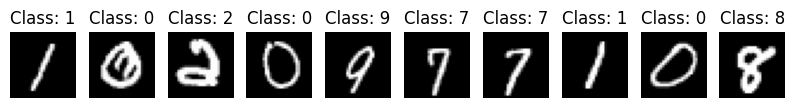

In [6]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [7]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [8]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

LinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer_1): Linear(in_features=784, out_features=10, bias=True)
)


In [9]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [10]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [11]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [12]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.5042526854674021, accuracy: 87.4875
Epoch 0: val. loss: 0.49664721019724584, val. accuracy: 87.52499999999999
Epoch 1: training loss: 0.42277956314881643, accuracy: 88.9375
Epoch 1: val. loss: 0.4135110409969979, val. accuracy: 88.88333333333334
Epoch 2: training loss: 0.38845122877756755, accuracy: 89.67500000000001
Epoch 2: val. loss: 0.37857449435173196, val. accuracy: 89.47500000000001
Epoch 3: training loss: 0.36831027662754057, accuracy: 90.08333333333334
Epoch 3: val. loss: 0.3582275088163132, val. accuracy: 89.85
Epoch 4: training loss: 0.3546269072294235, accuracy: 90.40833333333333
Epoch 4: val. loss: 0.34453047891246513, val. accuracy: 90.23333333333333
CPU times: user 1min 11s, sys: 70.4 ms, total: 1min 11s
Wall time: 1min 13s


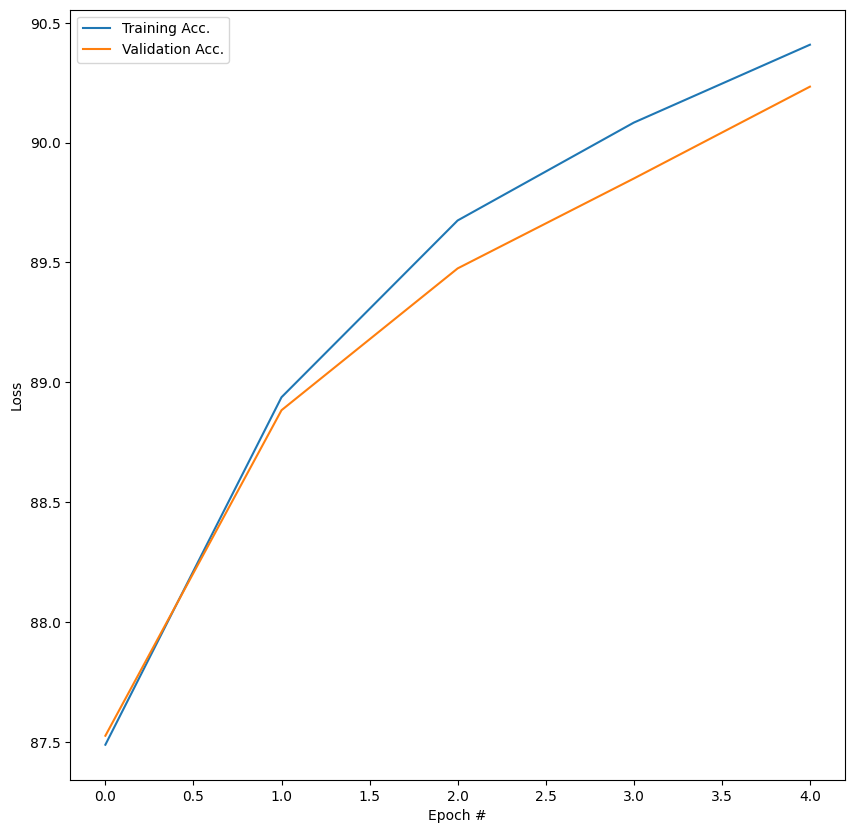

In [13]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

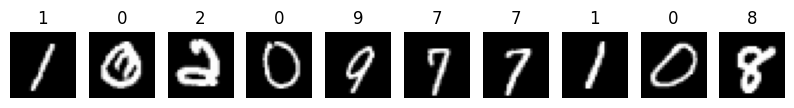

In [15]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [16]:
#For HW: cell to change batch size
#create dataloader for test data
# The dataloader makes our dataset iterable

batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [17]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

Test loss: 0.3332, test accuracy: 90.90%


We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [18]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


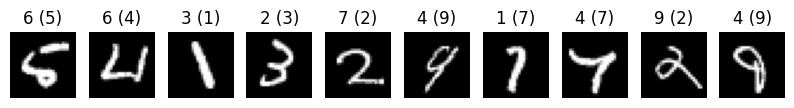

In [19]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [20]:
#For HW: cell to change activation
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [21]:
#### For HW: cell to change learning rate
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [22]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 0: training loss: 0.2640586787002782, accuracy: 92.24791666666667
Epoch 0: val. loss: 0.26032326511542003, val. accuracy: 91.90833333333333
Epoch 1: training loss: 0.17531238682785383, accuracy: 94.71458333333334
Epoch 1: val. loss: 0.18437921491265297, val. accuracy: 94.39999999999999
Epoch 2: training loss: 0.1364116040946295, accuracy: 95.90625
Epoch 2: val. loss: 0.14783608938381076, val. accuracy: 95.525
Epoch 3: training loss: 0.12186186682758852, accuracy: 96.31875
Epoch 3: val. loss: 0.13948559845983982, val. accuracy: 95.85000000000001
Epoch 4: training loss: 0.10195779532768454, accuracy: 96.88125
Epoch 4: val. loss: 0.12405908824130893, val. accuracy: 96.39999999999999
CPU times: user 1min 28s, sys: 200 ms, total: 1min 28s
Wall time: 1min 29s


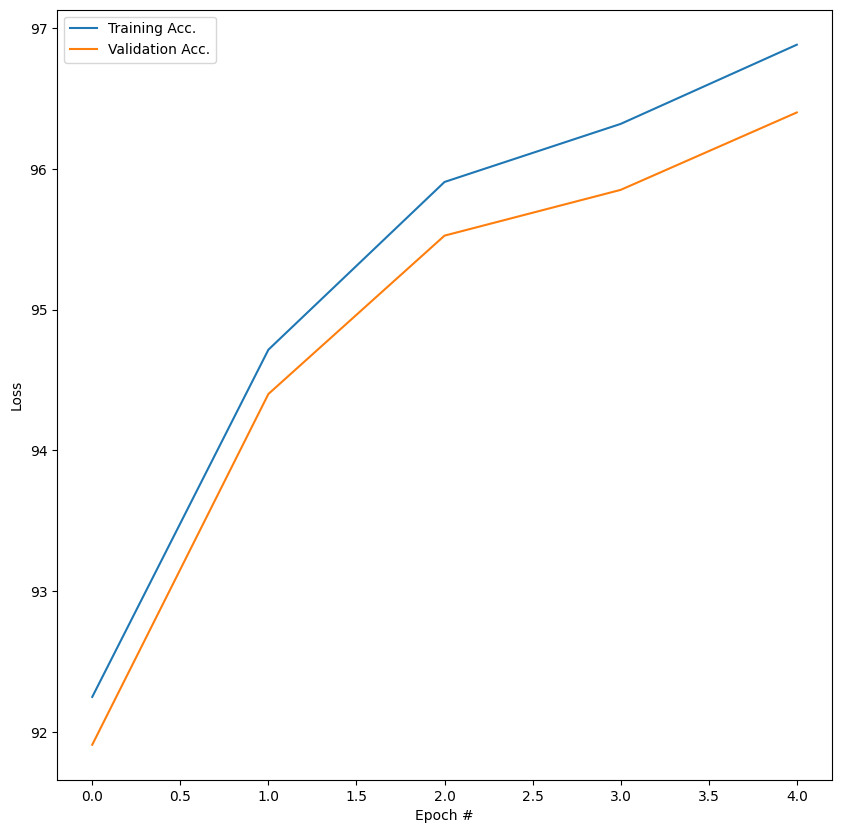

In [23]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

Showing max 10 first failures. The predicted class is shown first and the correct class in parentheses.


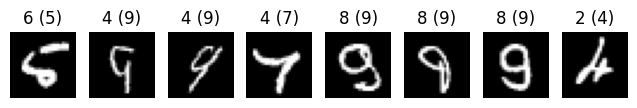

In [24]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

# Homework 2



Testing with Batch Size: 32
Epoch 0: Train Acc: 91.84%, Val Acc: 91.74%
Epoch 1: Train Acc: 95.16%, Val Acc: 94.96%
Epoch 2: Train Acc: 95.95%, Val Acc: 95.58%
Epoch 3: Train Acc: 96.44%, Val Acc: 96.08%
Epoch 4: Train Acc: 96.86%, Val Acc: 96.35%


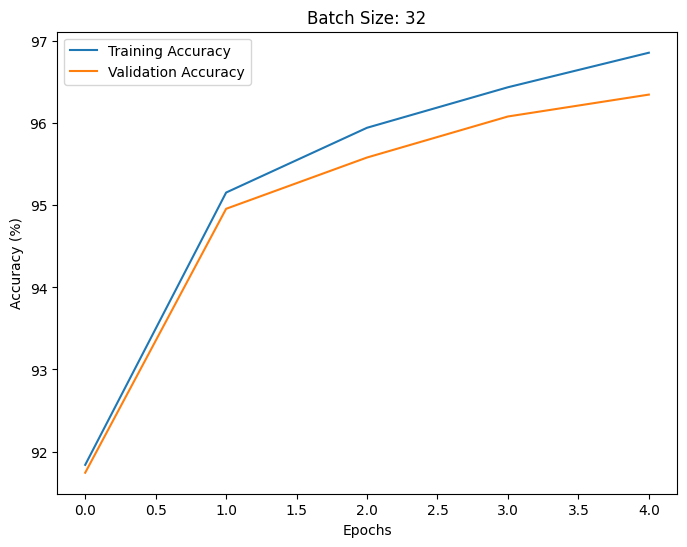


Testing with Batch Size: 64
Epoch 0: Train Acc: 88.47%, Val Acc: 88.14%
Epoch 1: Train Acc: 92.56%, Val Acc: 92.51%
Epoch 2: Train Acc: 94.43%, Val Acc: 94.22%
Epoch 3: Train Acc: 95.50%, Val Acc: 95.24%
Epoch 4: Train Acc: 96.07%, Val Acc: 95.49%


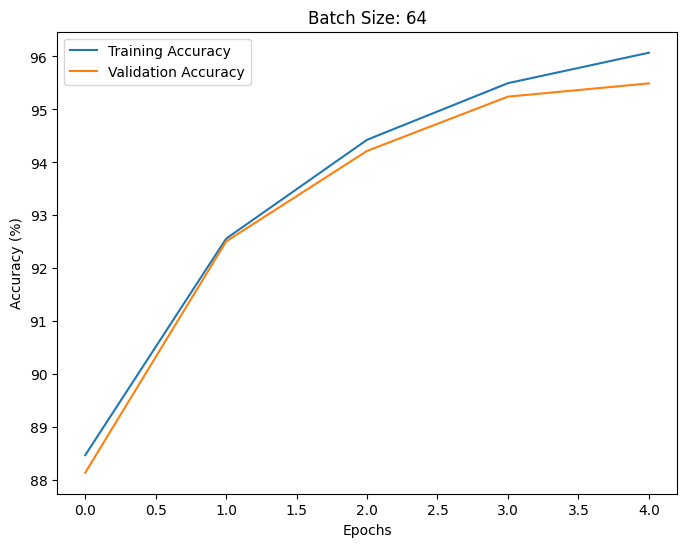


Testing with Batch Size: 128
Epoch 0: Train Acc: 76.64%, Val Acc: 76.51%
Epoch 1: Train Acc: 88.81%, Val Acc: 88.85%
Epoch 2: Train Acc: 91.06%, Val Acc: 91.01%
Epoch 3: Train Acc: 92.92%, Val Acc: 92.61%
Epoch 4: Train Acc: 93.80%, Val Acc: 93.78%


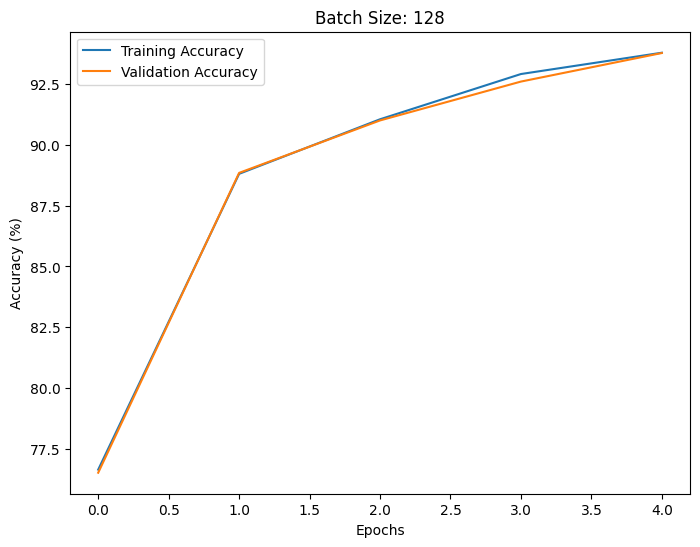


Testing with Batch Size: 256
Epoch 0: Train Acc: 44.03%, Val Acc: 44.22%
Epoch 1: Train Acc: 78.83%, Val Acc: 78.77%
Epoch 2: Train Acc: 85.53%, Val Acc: 85.65%
Epoch 3: Train Acc: 88.34%, Val Acc: 88.36%
Epoch 4: Train Acc: 90.21%, Val Acc: 90.25%


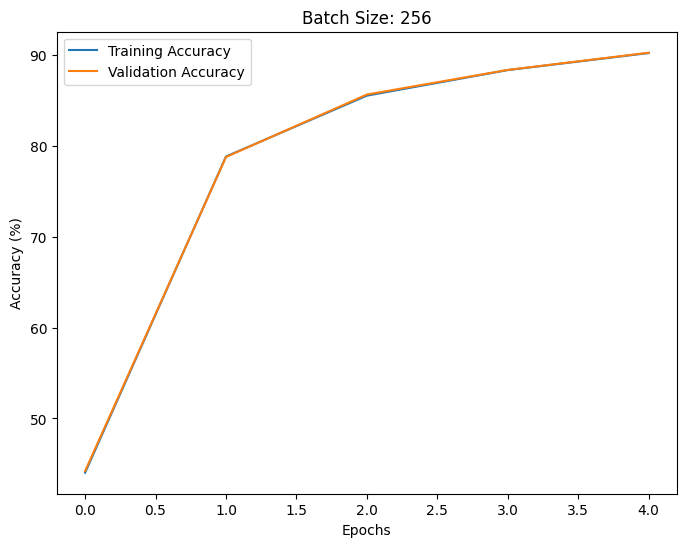


Testing with Learning Rate: 0.01
Epoch 0: Train Acc: 19.15%, Val Acc: 19.53%
Epoch 1: Train Acc: 35.88%, Val Acc: 35.91%
Epoch 2: Train Acc: 51.97%, Val Acc: 52.48%
Epoch 3: Train Acc: 72.47%, Val Acc: 71.95%
Epoch 4: Train Acc: 78.24%, Val Acc: 78.31%


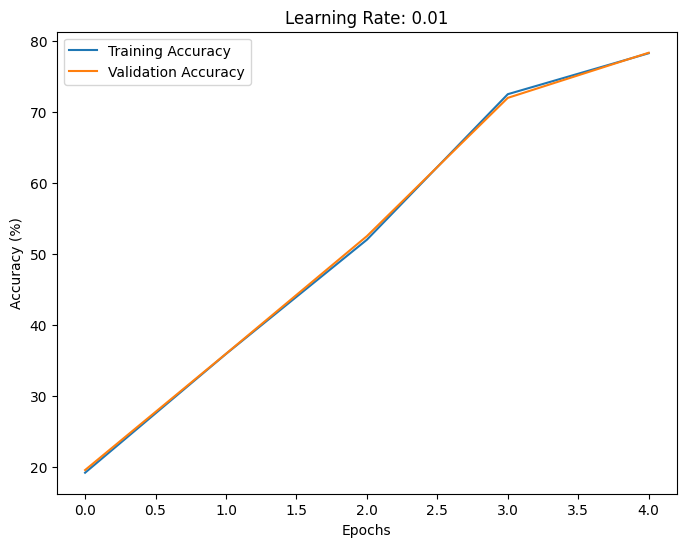


Testing with Learning Rate: 0.05
Epoch 0: Train Acc: 80.55%, Val Acc: 80.25%
Epoch 1: Train Acc: 88.34%, Val Acc: 88.29%
Epoch 2: Train Acc: 90.96%, Val Acc: 90.90%
Epoch 3: Train Acc: 92.55%, Val Acc: 92.29%
Epoch 4: Train Acc: 93.63%, Val Acc: 93.38%


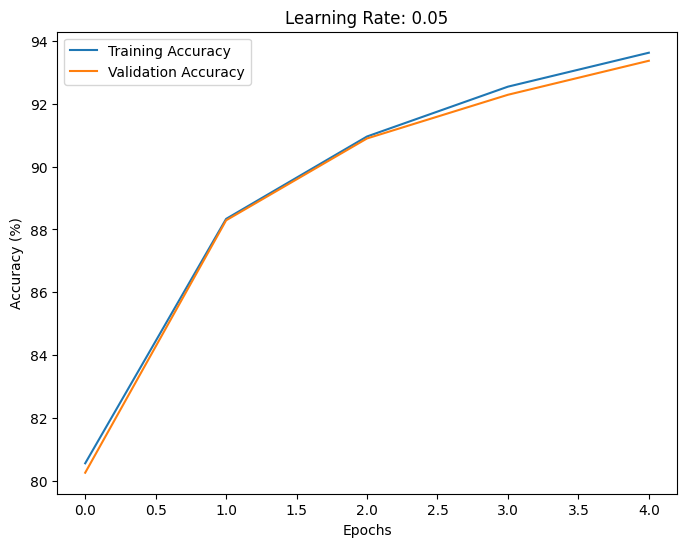


Testing with Learning Rate: 0.1
Epoch 0: Train Acc: 88.15%, Val Acc: 88.23%
Epoch 1: Train Acc: 92.39%, Val Acc: 92.22%
Epoch 2: Train Acc: 94.31%, Val Acc: 94.10%
Epoch 3: Train Acc: 95.30%, Val Acc: 95.02%
Epoch 4: Train Acc: 95.94%, Val Acc: 95.62%


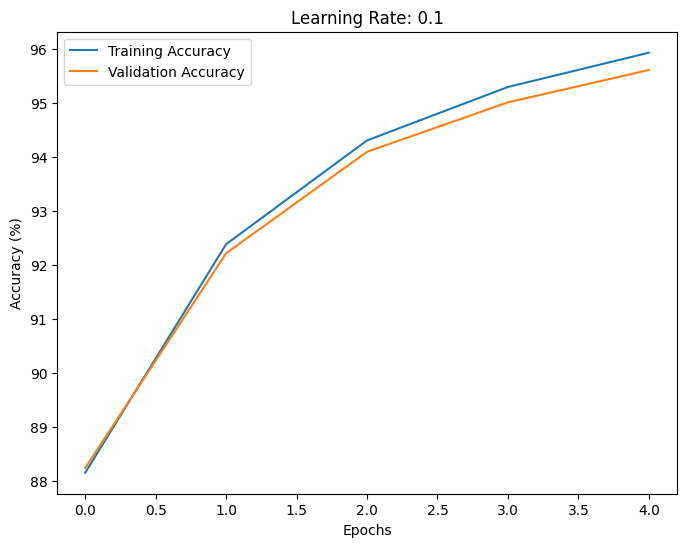


Testing with Activation: ReLU
Epoch 0: Train Acc: 80.39%, Val Acc: 80.00%
Epoch 1: Train Acc: 88.58%, Val Acc: 88.58%
Epoch 2: Train Acc: 91.21%, Val Acc: 91.23%
Epoch 3: Train Acc: 92.67%, Val Acc: 92.50%
Epoch 4: Train Acc: 93.61%, Val Acc: 93.41%


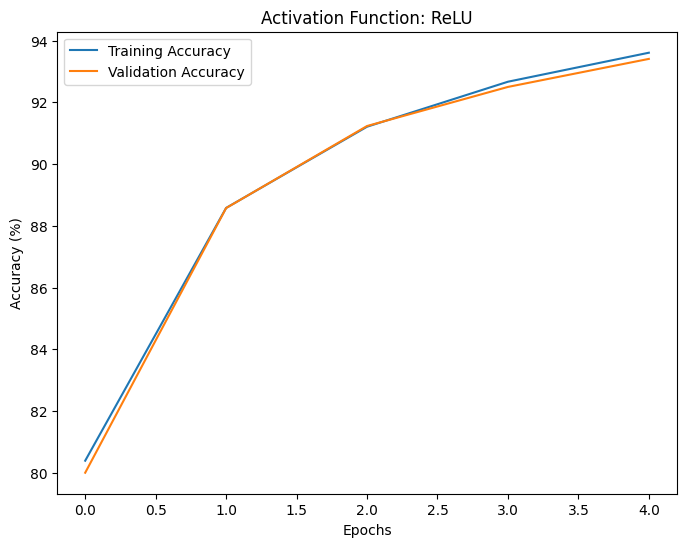


Testing with Activation: Sigmoid
Epoch 0: Train Acc: 11.24%, Val Acc: 11.23%
Epoch 1: Train Acc: 11.24%, Val Acc: 11.23%
Epoch 2: Train Acc: 11.24%, Val Acc: 11.23%
Epoch 3: Train Acc: 11.24%, Val Acc: 11.23%
Epoch 4: Train Acc: 11.24%, Val Acc: 11.23%


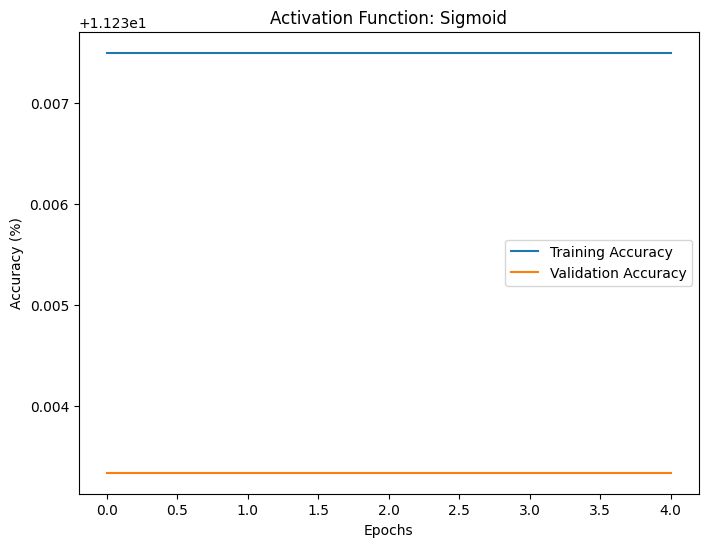


Testing with Activation: Tanh
Epoch 0: Train Acc: 85.00%, Val Acc: 84.83%
Epoch 1: Train Acc: 89.52%, Val Acc: 89.57%
Epoch 2: Train Acc: 91.08%, Val Acc: 90.85%
Epoch 3: Train Acc: 91.97%, Val Acc: 91.67%
Epoch 4: Train Acc: 92.52%, Val Acc: 92.12%


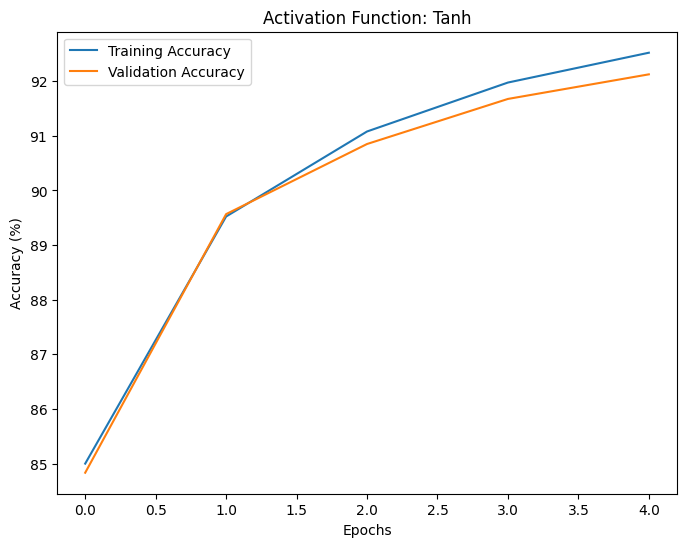

In [25]:

def evaluate_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs):
    train_acc_all = []
    val_acc_all = []
    for epoch in range(epochs):
        train_one_epoch(train_dataloader, model, loss_fn, optimizer)
        train_acc, train_loss = evaluate(train_dataloader, model, loss_fn)
        val_acc, val_loss = evaluate(val_dataloader, model, loss_fn)
        train_acc_all.append(train_acc)
        val_acc_all.append(val_acc)
        print(f"Epoch {epoch}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
    return train_acc_all, val_acc_all

# Plotting function
def plot_results(train_acc, val_acc, param_name, param_value):
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(train_acc)), train_acc, label="Training Accuracy")
    plt.plot(range(len(val_acc)), val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{param_name}: {param_value}")
    plt.legend()
    plt.show()

# Experiment 1: Vary Batch Sizes
batch_sizes = [32, 64, 128, 256]
for batch_size in batch_sizes:
    print(f"\nTesting with Batch Size: {batch_size}")
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
    nonlinear_model = NonlinearClassifier()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)
    train_acc, val_acc = evaluate_model(nonlinear_model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=5)
    plot_results(train_acc, val_acc, "Batch Size", batch_size)

# Experiment 2: Vary Learning Rates
learning_rates = [0.01, 0.05, 0.1]
for lr in learning_rates:
    print(f"\nTesting with Learning Rate: {lr}")
    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=128)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=128)
    nonlinear_model = NonlinearClassifier()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=lr)
    train_acc, val_acc = evaluate_model(nonlinear_model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=5)
    plot_results(train_acc, val_acc, "Learning Rate", lr)

# Experiment 3: Vary Activation Functions
activations = [nn.ReLU, nn.Sigmoid, nn.Tanh]
for activation in activations:
    print(f"\nTesting with Activation: {activation.__name__}")
    class NonlinearClassifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.layers_stack = nn.Sequential(
                nn.Linear(28 * 28, 50),
                activation(),
                nn.Dropout(0.2),
                nn.Linear(50, 50),
                activation(),
                nn.Linear(50, 50),
                activation(),
                nn.Linear(50, 10),
            )

        def forward(self, x):
            x = self.flatten(x)
            x = self.layers_stack(x)
            return x

    train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=128)
    val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=128)
    nonlinear_model = NonlinearClassifier()
    optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)
    train_acc, val_acc = evaluate_model(nonlinear_model, loss_fn, optimizer, train_dataloader, val_dataloader, epochs=5)
    plot_results(train_acc, val_acc, "Activation Function", activation.__name__)


In [26]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
for epoch in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    scheduler.step()  # Adjust learning rate after every epoch


In [ ]:
#####################To modify the batch size##########################
batch_size = 32 # 64, 128, 256, 512

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)
##############################################################################


##########################To change the learning rate##########################
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01) #modify the value of lr
##############################################################################


##########################To change activation##########################
###### Go to https://pytorch.org/docs/main/nn.html#non-linear-activations-weighted-sum-nonlinearity for more activations ######
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.Sigmoid(), #nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.Tanh(), #nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x
##############################################################################

Bonus question: A learning rate scheduler is an essential deep learning technique used to dynamically adjust the learning rate during training. This strategic can significantly impact the convergence speed and overall performance of a neural network.See below on how to incorporate it to your training.

In [ ]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.1)

# Step learning rate scheduler: reduce by a factor of 0.1 every 2 epochs (only for illustrative purposes)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
%%time

epochs = 6
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    #step the scheduler
    scheduler.step()

    # Print the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {j+1}/{epochs}, Learning Rate: {current_lr}")

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

Epoch 1/6, Learning Rate: 0.1
Epoch 0: training loss: 0.3729931376775106, accuracy: 89.26875
Epoch 0: val. loss: 0.36384286838769914, val. accuracy: 89.29166666666667
Epoch 2/6, Learning Rate: 0.010000000000000002
Epoch 1: training loss: 0.24737287873774766, accuracy: 92.67916666666667
Epoch 1: val. loss: 0.24119560087223849, val. accuracy: 92.73333333333333
Epoch 3/6, Learning Rate: 0.010000000000000002
Epoch 2: training loss: 0.23363943438356122, accuracy: 93.12708333333333
Epoch 2: val. loss: 0.22890273841718833, val. accuracy: 93.10833333333333
Epoch 4/6, Learning Rate: 0.0010000000000000002
Epoch 3: training loss: 0.22633988959466417, accuracy: 93.37083333333334
Epoch 3: val. loss: 0.22283465002973873, val. accuracy: 93.28333333333333
Epoch 5/6, Learning Rate: 0.0010000000000000002
Epoch 4: training loss: 0.2252282265871763, accuracy: 93.37291666666667
Epoch 4: val. loss: 0.221913401906689, val. accuracy: 93.30833333333334
Epoch 6/6, Learning Rate: 0.00010000000000000003
Epoch 5: 